Phase 1: Qiskit Fundamentals & Feature Analysis Goal: Understand quantum circuit creation, simulation, measurement, and feature extraction

This notebook demonstrates:

Creating Bell states (entangled states)
Creating random quantum circuits
Running noiseless simulations
Extracting and analyzing measurement results
Computing statistical features from quantum measurements
Baseline feature distributions (will compare to noisy circuits later)
In Phase 1, we're establishing what CLEAN quantum measurement looks like.

In [13]:
# Cell 1: Imports and Configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,5)
np.random.seed(42)

In [15]:
# ============================================================================
# PART 1: Bell States (Maximally Entangled States)
# ============================================================================

def create_bell_state(bell_type=0):
    """
    Create Bell states - maximally entangled two-qubit states.
    
    Bell states are:
    |Φ+⟩ = (|00⟩ + |11⟩)/√2  (bell_type=0)
    |Φ-⟩ = (|00⟩ - |11⟩)/√2  (bell_type=1)
    |Ψ+⟩ = (|01⟩ + |10⟩)/√2  (bell_type=2)
    |Ψ-⟩ = (|01⟩ - |10⟩)/√2  (bell_type=3)
    
    Args:
        bell_type: Integer 0-3 specifying which Bell state
    
    Returns:
        QuantumCircuit: A 2-qubit circuit preparing the Bell state
    """
    qc = QuantumCircuit(2, name=f'Bell_{bell_type}')
    
    # First, create superposition on qubit 0
    qc.h(0)
    
    # Then entangle with qubit 1
    qc.cx(0, 1)
    
    # Apply additional gates based on bell_type
    if bell_type == 1:
        qc.z(0)
    elif bell_type == 2:
        qc.x(1)
    elif bell_type == 3:
        qc.x(1)
        qc.z(0)
    
    return qc

In [17]:
def create_random_circuit(num_qubits=3, depth=5, seed=None):
    """
    Create a random quantum circuit with random single and two-qubit gates.
    
    Args:
        num_qubits: Number of qubits in the circuit
        depth: Number of circuit layers (higher = more complex)
        seed: Random seed for reproducibility
    
    Returns:
        QuantumCircuit: A random quantum circuit
    """
    if seed is not None:
        np.random.seed(seed)
    
    qc = QuantumCircuit(num_qubits)
    
    single_gates = ['h', 'x', 'y', 'z', 's', 't']
    two_qubit_gates = ['cx', 'cy', 'cz']
    
    for layer in range(depth):
        # Random single-qubit gates
        for qubit in range(num_qubits):
            gate = np.random.choice(single_gates)
            getattr(qc, gate)(qubit)
        
        # Random two-qubit gates
        for qubit in range(num_qubits - 1):
            if np.random.rand() > 0.3:  # 70% chance of two-qubit gate
                gate = np.random.choice(two_qubit_gates)
                getattr(qc, gate)(qubit, qubit + 1)
    
    return qc

In [19]:
# ============================================================================
# PART 2: Measurement and Simulation
# ============================================================================

def run_circuit_with_measurement(circuit, shots=1024):
    """
    Add measurement to circuit and run simulation.
    
    Args:
        circuit: QuantumCircuit to measure
        shots: Number of times to measure (trials)
    
    Returns:
        dict: Measurement counts (state -> count)
        dict: Probability distribution (state -> probability)
    """
    # Create a copy and add measurements
    qc = circuit.copy()
    num_qubits = circuit.num_qubits
    qc.measure_all()
    
    # Simulate
    simulator = AerSimulator()
    job = simulator.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    # Convert to probabilities
    probabilities = {state: count / shots for state, count in counts.items()}
    
    return counts, probabilities

In [21]:
def visualize_measurement_results(probabilities, title="Measurement Results"):
    """
    Visualize measurement probability distribution as a bar plot.
    
    Args:
        probabilities: Dict mapping states to probabilities
        title: Title for the plot
    """
    states = list(probabilities.keys())
    probs = list(probabilities.values())
    
    plt.figure(figsize=(12, 4))
    plt.bar(states, probs, color='steelblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Quantum State (measurement outcome)')
    plt.ylabel('Probability')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [23]:

# ============================================================================
# PART 3: Statistical Feature Extraction
# ============================================================================

def extract_features(probabilities):
    """
    Extract comprehensive statistical features from measurement probability distribution.
    
    These features will be used to distinguish different noise types in Phase 2.
    
    Args:
        probabilities: Dict mapping states to probabilities
    
    Returns:
        dict: Features for classification
    """
    probs_array = np.array(list(probabilities.values()))
    states_array = np.array(list(probabilities.keys()), dtype=int)
    
    # Feature 1: Entropy (uncertainty in measurement outcomes)
    # High entropy = many equally likely outcomes
    # Low entropy = concentrated in few states
    entropy = -np.sum(probs_array * np.log2(probs_array + 1e-10))
    
    # Feature 2: Maximum probability
    max_prob = np.max(probs_array)
    
    # Feature 3: Number of states with significant probability
    num_nonzero = np.sum(probs_array > 0.01)
    
    # Feature 4: Uniformity measure (entropy normalized)
    max_entropy = np.log2(len(probs_array)) if len(probs_array) > 0 else 1
    uniformity = entropy / max_entropy if max_entropy > 0 else 0
    
    # Feature 5: Probability skewness
    # How asymmetric is the distribution?
    skewness = stats.skew(probs_array) if len(probs_array) > 2 else 0
    
    # Feature 6: Probability kurtosis
    # How heavy are the tails?
    kurtosis = stats.kurtosis(probs_array) if len(probs_array) > 3 else 0
    
    # Feature 7: Mean probability (should be 1/num_states for uniform)
    mean_prob = np.mean(probs_array)
    
    # Feature 8: Variance of probabilities
    var_prob = np.var(probs_array)
    
    # Feature 9: Purity (sum of squared probabilities)
    # High purity = pure state, Low purity = mixed state
    purity = np.sum(probs_array ** 2)
    
    features = {
        'entropy': entropy,
        'max_probability': max_prob,
        'num_nonzero_states': num_nonzero,
        'uniformity': uniformity,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'mean_probability': mean_prob,
        'variance_probability': var_prob,
        'purity': purity
    }
    
    return features

In [25]:
# ============================================================================
# PART 4: Baseline Feature Analysis
# ============================================================================

def analyze_feature_distributions(circuits_dict, shots=1024):
    """
    Measure features across multiple circuits and analyze distributions.
    
    This establishes BASELINE (noiseless) feature distributions.
    In Phase 2, we'll compare these to noisy versions.
    
    Args:
        circuits_dict: Dict mapping circuit names to QuantumCircuit objects
        shots: Number of measurement shots
    
    Returns:
        pd.DataFrame: Features for all circuits
    """
    all_features = []
    
    for name, circuit in circuits_dict.items():
        counts, probs = run_circuit_with_measurement(circuit, shots=shots)
        features = extract_features(probs)
        features['circuit_name'] = name
        features['num_qubits'] = circuit.num_qubits
        all_features.append(features)
    
    df = pd.DataFrame(all_features)
    return df

In [27]:
def plot_feature_distributions(df, feature_names=None):
    """
    Visualize feature distributions across circuits.
    
    Args:
        df: DataFrame with features
        feature_names: List of features to plot (default: all)
    """
    if feature_names is None:
        feature_names = [col for col in df.columns if col not in ['circuit_name', 'num_qubits']]
    
    num_features = len(feature_names)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, feature in enumerate(feature_names[:8]):
        axes[idx].hist(df[feature], bins=10, alpha=0.7, color='steelblue', edgecolor='black')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'{feature} Distribution')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [29]:
def print_feature_statistics(df, feature_names=None):
    """
    Print statistical summary of features.
    
    Args:
        df: DataFrame with features
        feature_names: List of features (default: all)
    """
    if feature_names is None:
        feature_names = [col for col in df.columns if col not in ['circuit_name', 'num_qubits']]
    
    print("\n" + "="*70)
    print("BASELINE FEATURE STATISTICS (Noiseless Circuits)")
    print("="*70)
    print(df[feature_names].describe().round(4))
    print("\n")

PHASE 1: QISKIT FUNDAMENTALS & FEATURE ANALYSIS

1. BELL STATES (Entangled States)
----------------------------------------------------------------------

Bell State 0:
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
Measurement results: {'00': 0.5029296875, '11': 0.4970703125}
Features:
  entropy: 1.0000
  max_probability: 0.5029
  num_nonzero_states: 2.0000
  uniformity: 1.0000
  skewness: 0.0000
  kurtosis: 0.0000
  mean_probability: 0.5000
  variance_probability: 0.0000
  purity: 0.5000


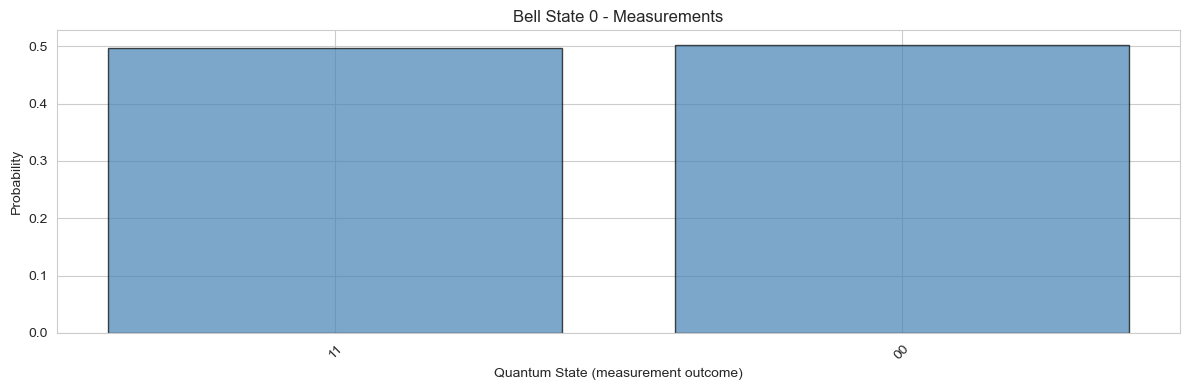


Bell State 1:
     ┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ Z ├
     └───┘┌─┴─┐└───┘
q_1: ─────┤ X ├─────
          └───┘     
Measurement results: {'00': 0.5107421875, '11': 0.4892578125}
Features:
  entropy: 0.9997
  max_probability: 0.5107
  num_nonzero_states: 2.0000
  uniformity: 0.9997
  skewness: 0.0000
  kurtosis: 0.0000
  mean_probability: 0.5000
  variance_probability: 0.0001
  purity: 0.5002


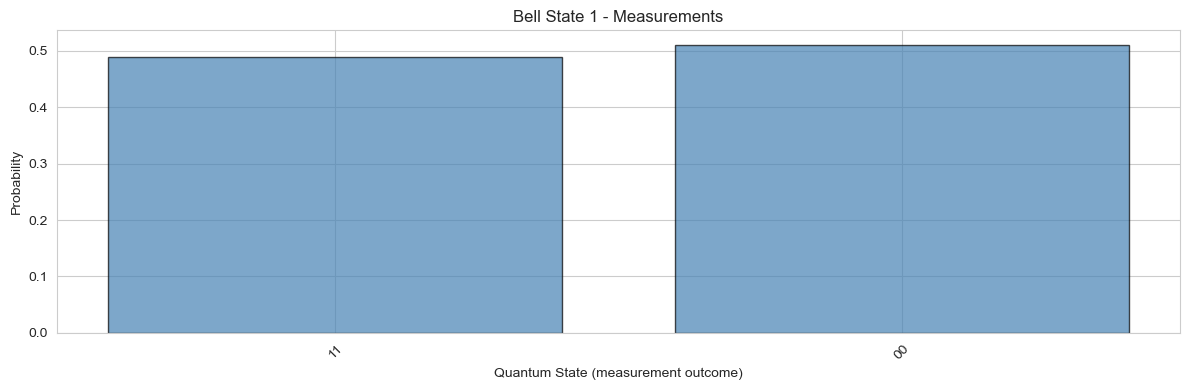


Bell State 2:
     ┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐┌───┐
q_1: ─────┤ X ├┤ X ├
          └───┘└───┘
Measurement results: {'01': 0.515625, '10': 0.484375}
Features:
  entropy: 0.9993
  max_probability: 0.5156
  num_nonzero_states: 2.0000
  uniformity: 0.9993
  skewness: 0.0000
  kurtosis: 0.0000
  mean_probability: 0.5000
  variance_probability: 0.0002
  purity: 0.5005


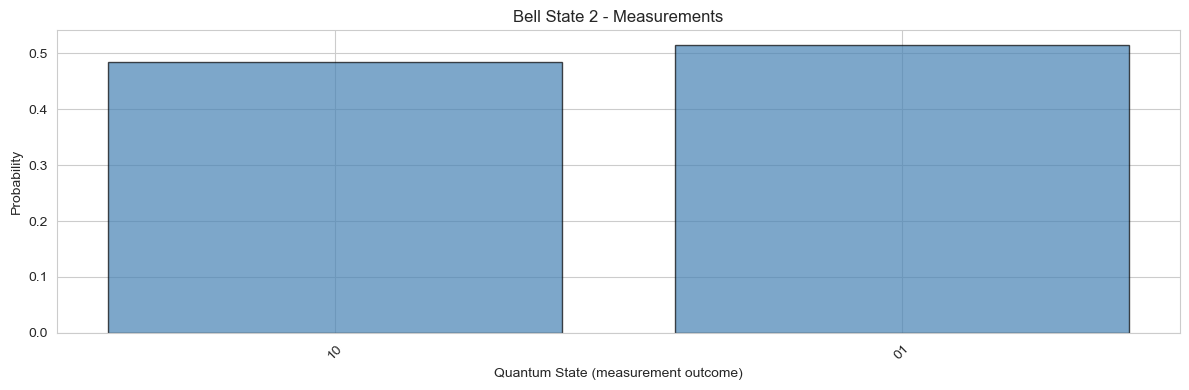


Bell State 3:
     ┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ Z ├
     └───┘┌─┴─┐├───┤
q_1: ─────┤ X ├┤ X ├
          └───┘└───┘
Measurement results: {'01': 0.5205078125, '10': 0.4794921875}
Features:
  entropy: 0.9988
  max_probability: 0.5205
  num_nonzero_states: 2.0000
  uniformity: 0.9988
  skewness: 0.0000
  kurtosis: 0.0000
  mean_probability: 0.5000
  variance_probability: 0.0004
  purity: 0.5008


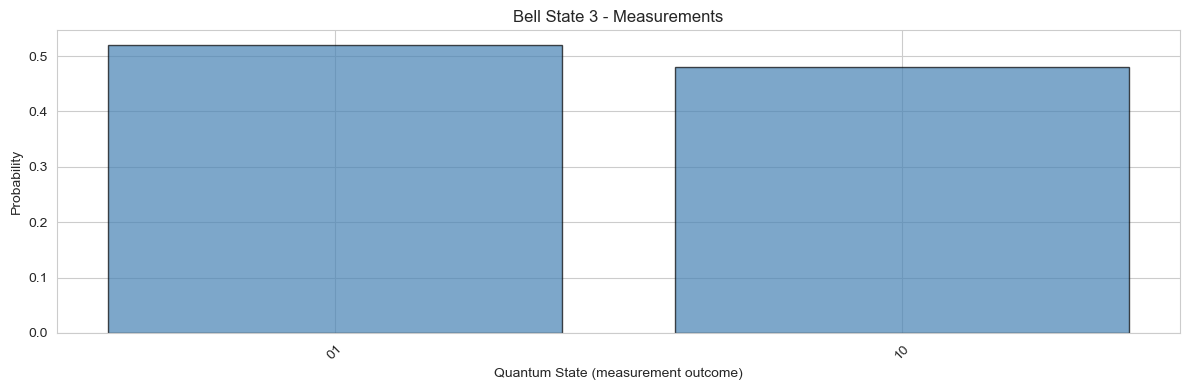



2. RANDOM QUANTUM CIRCUITS
----------------------------------------------------------------------

Random Circuit 1 (3 qubits, depth 5):
     ┌───┐     ┌───┐     ┌───┐┌───┐     ┌───┐        
q_0: ┤ Z ├──■──┤ Y ├──■──┤ X ├┤ S ├──■──┤ Y ├────────
     ├───┤┌─┴─┐├───┤  │  ├───┤├───┤┌─┴─┐└───┘┌───┐   
q_1: ┤ S ├┤ X ├┤ Y ├──■──┤ Z ├┤ H ├┤ X ├──■──┤ Y ├─■─
     ├───┤├───┤├───┤┌───┐└───┘└───┘└───┘┌─┴─┐├───┤ │ 
q_2: ┤ Y ├┤ Y ├┤ T ├┤ Z ├───────────────┤ X ├┤ X ├─■─
     └───┘└───┘└───┘└───┘               └───┘└───┘   
Number of possible states: 2
Top 5 most likely outcomes:
  111: 0.5195
  001: 0.4805
Features:
  entropy: 0.9989
  max_probability: 0.5195
  num_nonzero_states: 2.0000
  uniformity: 0.9989
  skewness: 0.0000
  kurtosis: 0.0000
  mean_probability: 0.5000
  variance_probability: 0.0004
  purity: 0.5008


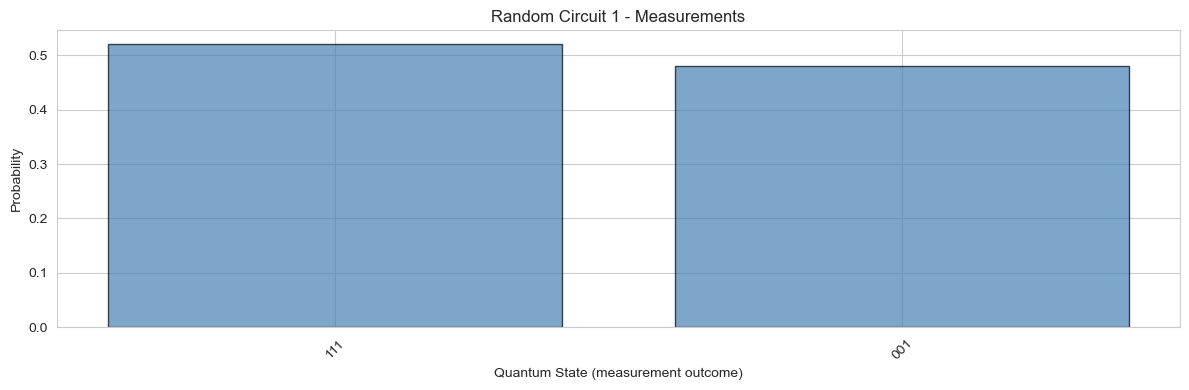


Random Circuit 2 (3 qubits, depth 5):
     ┌───┐┌───┐┌───┐┌───┐     ┌───┐     
q_0: ┤ S ├┤ X ├┤ H ├┤ Y ├──■──┤ T ├─────
     ├───┤├───┤├───┤├───┤┌─┴─┐├───┤     
q_1: ┤ H ├┤ Z ├┤ Z ├┤ Z ├┤ X ├┤ S ├──■──
     ├───┤├───┤├───┤├───┤├───┤└───┘┌─┴─┐
q_2: ┤ X ├┤ Z ├┤ Y ├┤ Y ├┤ H ├─────┤ X ├
     └───┘└───┘└───┘└───┘└───┘     └───┘
Number of possible states: 8
Top 5 most likely outcomes:
  001: 0.1445
  000: 0.1426
  101: 0.1328
  010: 0.1211
  100: 0.1182
Features:
  entropy: 2.9929
  max_probability: 0.1445
  num_nonzero_states: 8.0000
  uniformity: 0.9976
  skewness: 0.4545
  kurtosis: -1.2669
  mean_probability: 0.1250
  variance_probability: 0.0002
  purity: 0.1262


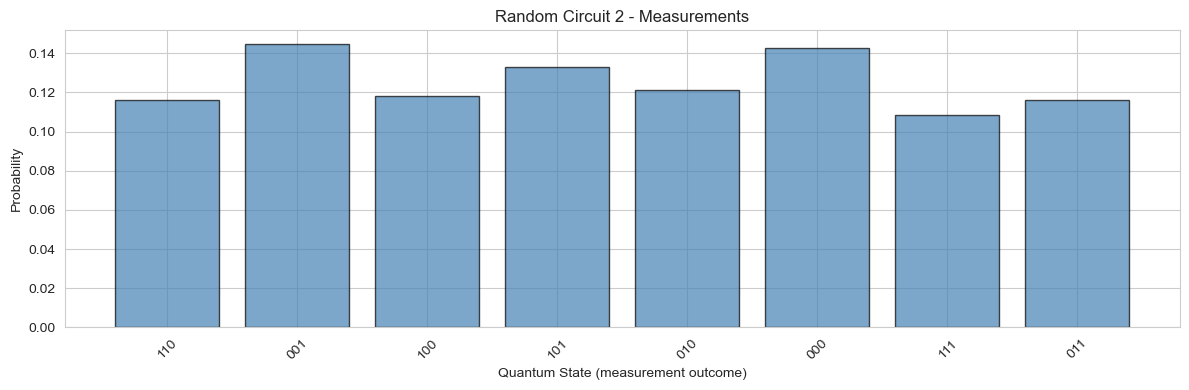


Random Circuit 3 (3 qubits, depth 5):
     ┌───┐┌───┐          ┌───┐     ┌───┐          ┌───┐        
q_0: ┤ S ├┤ Z ├───────■──┤ Z ├──■──┤ H ├───────■──┤ Y ├────────
     ├───┤└───┘┌───┐  │  ├───┤┌─┴─┐└───┘┌───┐┌─┴─┐└───┘┌───┐   
q_1: ┤ Z ├──■──┤ Y ├──■──┤ Z ├┤ Y ├──■──┤ S ├┤ X ├──■──┤ H ├─■─
     ├───┤┌─┴─┐├───┤┌───┐└───┘└───┘  │  ├───┤└───┘┌─┴─┐├───┤ │ 
q_2: ┤ X ├┤ X ├┤ H ├┤ T ├────────────■──┤ T ├─────┤ Y ├┤ T ├─■─
     └───┘└───┘└───┘└───┘               └───┘     └───┘└───┘   
Number of possible states: 8
Top 5 most likely outcomes:
  100: 0.1396
  110: 0.1377
  011: 0.1299
  111: 0.1250
  101: 0.1221
Features:
  entropy: 2.9960
  max_probability: 0.1396
  num_nonzero_states: 8.0000
  uniformity: 0.9987
  skewness: 0.3550
  kurtosis: -1.3181
  mean_probability: 0.1250
  variance_probability: 0.0001
  purity: 0.1257


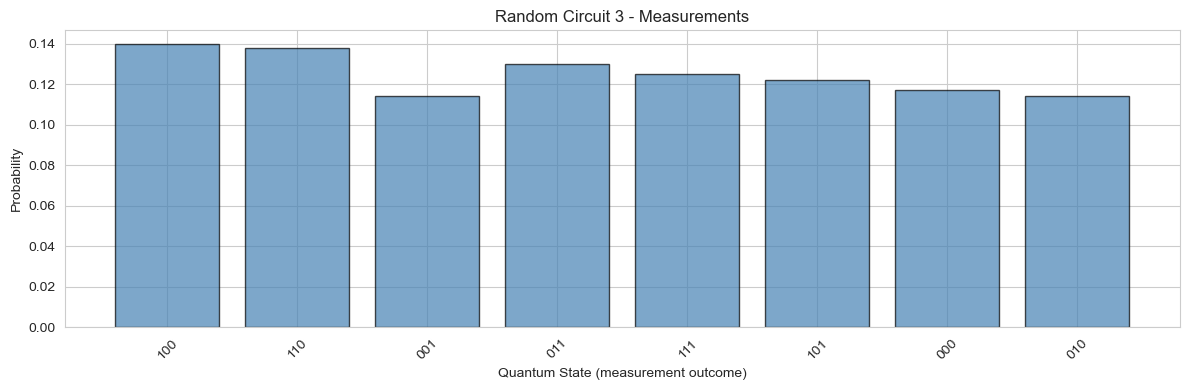


Random Circuit 4 (3 qubits, depth 5):
     ┌───┐┌───┐     ┌───┐   ┌───┐          ┌───┐        
q_0: ┤ Z ├┤ Z ├──■──┤ X ├─■─┤ X ├───────■──┤ S ├─■──────
     ├───┤├───┤┌─┴─┐├───┤ │ └───┘┌───┐┌─┴─┐├───┤ │      
q_1: ┤ Z ├┤ S ├┤ Y ├┤ H ├─■───■──┤ S ├┤ X ├┤ X ├─■───■──
     ├───┤├───┤├───┤└───┘   ┌─┴─┐├───┤├───┤└───┘   ┌─┴─┐
q_2: ┤ S ├┤ X ├┤ H ├────────┤ X ├┤ H ├┤ T ├────────┤ X ├
     └───┘└───┘└───┘        └───┘└───┘└───┘        └───┘
Number of possible states: 2
Top 5 most likely outcomes:
  010: 0.5049
  100: 0.4951
Features:
  entropy: 0.9999
  max_probability: 0.5049
  num_nonzero_states: 2.0000
  uniformity: 0.9999
  skewness: 0.0000
  kurtosis: 0.0000
  mean_probability: 0.5000
  variance_probability: 0.0000
  purity: 0.5000


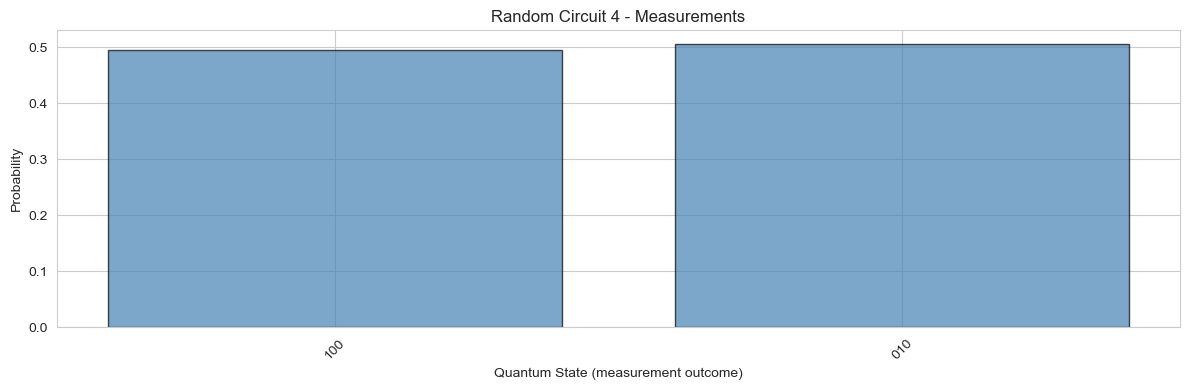


Random Circuit 5 (3 qubits, depth 5):
     ┌───┐     ┌───┐┌───┐          ┌───┐┌───┐          
q_0: ┤ T ├──■──┤ S ├┤ Y ├───────■──┤ H ├┤ H ├───────■──
     ├───┤  │  ├───┤└───┘┌───┐  │  ├───┤└───┘┌───┐┌─┴─┐
q_1: ┤ T ├──■──┤ Z ├──■──┤ Z ├──■──┤ S ├──■──┤ S ├┤ X ├
     ├───┤┌───┐└───┘  │  ├───┤┌───┐└───┘┌─┴─┐├───┤└───┘
q_2: ┤ H ├┤ H ├───────■──┤ Y ├┤ H ├─────┤ X ├┤ X ├─────
     └───┘└───┘          └───┘└───┘     └───┘└───┘     
Number of possible states: 2
Top 5 most likely outcomes:
  111: 0.5137
  011: 0.4863
Features:
  entropy: 0.9995
  max_probability: 0.5137
  num_nonzero_states: 2.0000
  uniformity: 0.9995
  skewness: 0.0000
  kurtosis: 0.0000
  mean_probability: 0.5000
  variance_probability: 0.0002
  purity: 0.5004


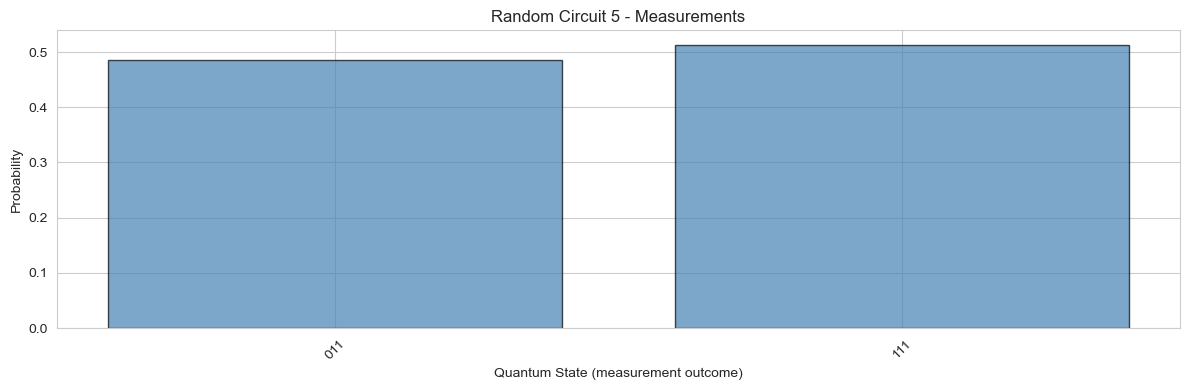



3. BASELINE FEATURE ANALYSIS
----------------------------------------------------------------------

BASELINE FEATURE STATISTICS (Noiseless Circuits)
       entropy  max_probability  num_nonzero_states  uniformity  skewness  \
count   9.0000           9.0000              9.0000      9.0000    9.0000   
mean    1.4434           0.4296              3.3333      0.9993    0.0053   
std     0.8814           0.1671              2.6458      0.0006    0.2093   
min     0.9980           0.1299              2.0000      0.9980   -0.3941   
25%     0.9992           0.5010              2.0000      0.9991    0.0000   
50%     0.9993           0.5156              2.0000      0.9993    0.0000   
75%     1.0000           0.5166              2.0000      0.9997    0.0000   
max     2.9991           0.5264              8.0000      1.0000    0.4420   

       kurtosis  mean_probability  variance_probability  purity  
count    9.0000            9.0000                9.0000  9.0000  
mean    -0.1827       

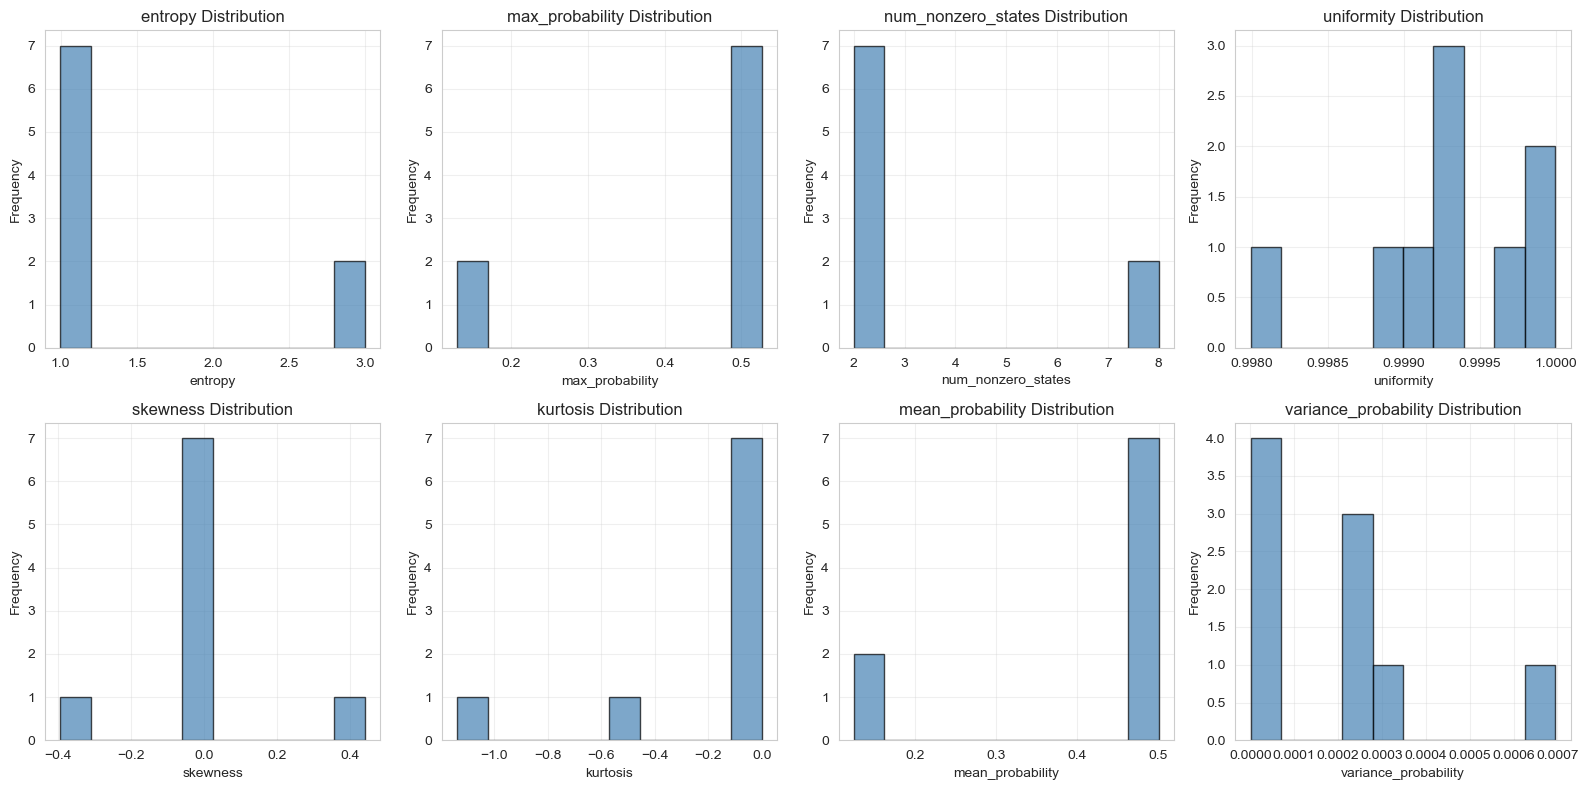



5. SAVING BASELINE DATA
----------------------------------------------------------------------
✓ Saved baseline features to 'phase1_baseline_features.csv'

Phase 1 Complete!

Key Takeaways:
✓ Bell states have LOW entropy (concentrated probabilities)
✓ Random circuits have HIGH entropy (spread-out probabilities)
✓ These features will help distinguish NOISE TYPES in Phase 2
✓ We established BASELINE (noiseless) feature distributions

Next: Phase 2 will add noise and measure how features CHANGE


In [37]:
# ============================================================================
# PART 5: Main Execution
# ============================================================================

if __name__ == "__main__":
    print("="*70)
    print("PHASE 1: QISKIT FUNDAMENTALS & FEATURE ANALYSIS")
    print("="*70)
    
    # --- Bell States ---
    print("\n1. BELL STATES (Entangled States)")
    print("-"*70)
    
    bell_circuits = {}
    bell_features = []
    
    for i in range(4):
        bell_circuit = create_bell_state(bell_type=i)
        bell_circuits[f'Bell_{i}'] = bell_circuit
        
        print(f"\nBell State {i}:")
        print(bell_circuit)
        
        counts, probs = run_circuit_with_measurement(bell_circuit, shots=1024)
        print(f"Measurement results: {dict(sorted(probs.items()))}")
        
        features = extract_features(probs)
        bell_features.append(features)
        print(f"Features:")
        for key, val in features.items():
            print(f"  {key}: {val:.4f}")
        
        visualize_measurement_results(probs, title=f"Bell State {i} - Measurements")
    
    # --- Random Circuits ---
    print("\n\n2. RANDOM QUANTUM CIRCUITS")
    print("-"*70)
    
    random_circuits = {}
    random_features = []
    
    for circuit_num in range(5):
        print(f"\nRandom Circuit {circuit_num + 1} (3 qubits, depth 5):")
        random_circuit = create_random_circuit(num_qubits=3, depth=5, seed=42 + circuit_num)
        random_circuits[f'Random_{circuit_num}'] = random_circuit
        
        print(random_circuit)
        
        counts, probs = run_circuit_with_measurement(random_circuit, shots=1024)
        print(f"Number of possible states: {len(probs)}")
        print(f"Top 5 most likely outcomes:")
        for state, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {state}: {prob:.4f}")
        
        features = extract_features(probs)
        random_features.append(features)
        print(f"Features:")
        for key, val in features.items():
            print(f"  {key}: {val:.4f}")
        
        visualize_measurement_results(probs, title=f"Random Circuit {circuit_num + 1} - Measurements")
    
    # --- Comprehensive Feature Analysis ---
    print("\n\n3. BASELINE FEATURE ANALYSIS")
    print("-"*70)
    
    all_circuits = {**bell_circuits, **random_circuits}
    df_features = analyze_feature_distributions(all_circuits, shots=1024)
    
    print_feature_statistics(df_features)
    
    print("\nComparison: Bell States vs. Random Circuits")
    print("-"*70)
    bell_df = df_features[df_features['circuit_name'].str.contains('Bell')]
    random_df = df_features[df_features['circuit_name'].str.contains('Random')]
    
    print("\nBell States - Feature Means:")
    print(bell_df[['entropy', 'max_probability', 'uniformity', 'purity']].mean().round(4))
    
    print("\nRandom Circuits - Feature Means:")
    print(random_df[['entropy', 'max_probability', 'uniformity', 'purity']].mean().round(4))
    
    # --- Visualize Feature Distributions ---
    print("\n\n4. FEATURE DISTRIBUTION VISUALIZATIONS")
    print("-"*70)
    
    plot_feature_distributions(df_features)
    
    # --- Save baseline data ---
    print("\n\n5. SAVING BASELINE DATA")
    print("-"*70)
    
    df_features.to_csv('phase1_baseline_features.csv', index=False)
    print("✓ Saved baseline features to 'phase1_baseline_features.csv'")
    
    print("\n" + "="*70)
    print("Phase 1 Complete!")
    print("="*70)
    print("\nKey Takeaways:")
    print("✓ Bell states have LOW entropy (concentrated probabilities)")
    print("✓ Random circuits have HIGH entropy (spread-out probabilities)")
    print("✓ These features will help distinguish NOISE TYPES in Phase 2")
    print("✓ We established BASELINE (noiseless) feature distributions")
    print("\nNext: Phase 2 will add noise and measure how features CHANGE")
    print("="*70)